In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP
from datasets import inputs, sf_inputs_discrete
from run_td_rnn import run as run_rnn
from run_td_mlp import run as run_mlp
from run_td_linear import run as run_linear

device = 'cpu'

/home/chingf/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/home/chingf/Code/sr-project/datasets/sf_inputs_discrete.py:19: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


# Option A: Specify dataset and run network

In [62]:
num_states = 20*20

In [64]:
# N-hot inputs
feature_maker_kwargs = {
    'feature_dim': num_states*2, 'feature_type': 'nhot'
    }

# Uncorrelated inputs
feature_maker_kwargs = {
    'feature_dim': num_states,
    'feature_vals': [0, 1],
    'feature_vals_p': [0.97, 0.03]
    }

# Correlated inputs
feature_maker_kwargs = {
    'feature_dim': num_states, 'feature_vals': None,
    'feature_vals_p': [0.8, 0.2],
    'feature_type': 'correlated_distributed',
    'spatial_sigma': 1.5
    }
# # One hot
# feature_maker_kwargs = {
#     'feature_dim': num_states, 'feature_type': 'nhot'
#     }

dataset_config = {
    'num_steps': 3500, 'num_states': num_states,
    'feature_maker_kwargs': feature_maker_kwargs
    }
dataset = sf_inputs_discrete.Sim2DWalk


dataset_config = {
    'feature_maker_kwargs': feature_maker_kwargs,
    'num_steps': np.inf
    }
dataset = sf_inputs_discrete.TitmouseWalk

input_size = feature_maker_kwargs['feature_dim']
seed = 3

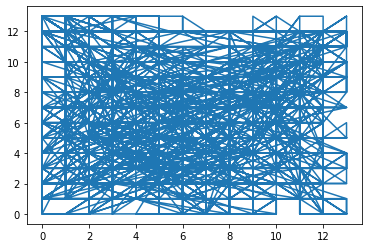

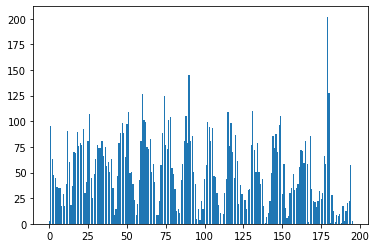

48.5


0.01020408163265306

In [65]:
np.random.seed(seed)
input = dataset(**dataset_config)
plt.figure();
plt.plot(input.xs, input.ys)
plt.show()

plt.figure();
states = np.argwhere(input.state_inputs)[:,0]
counts = np.zeros(input.num_states)
for state in np.arange(input.num_states):
    counts[state] = np.sum(states==state)
plt.bar(np.arange(input.num_states), counts)
plt.show()
print(np.median(counts))
np.sum(counts == 0)/input.num_states

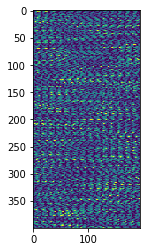

In [66]:
plt.figure()
plt.imshow(input.feature_maker.feature_map)
plt.show()

In [67]:
gamma=0.6

In [68]:
arena_length = int(np.sqrt(input.num_states)) - 1
walk_xs = input.xs.astype(int)
walk_ys = input.ys.astype(int)

In [69]:
input.dg_inputs.shape

(400, 10031)

In [70]:
T = np.zeros((num_states, num_states))
for i in range(1, input.dg_inputs.shape[1]):
    T += np.outer(input.dg_inputs[:,i-1], input.dg_inputs[:,i])
T = T/np.sum(T, axis=1)[:,None]
nan_idxs = np.argwhere(np.sum(np.isnan(T), axis=1))
if nan_idxs.size > 0:
    for nan_idx in nan_idxs:
        T[nan_idx,:] = np.zeros(num_states)
        T[nan_idx, (nan_idx-1)%num_states] = 1/3
        T[nan_idx, nan_idx] = 1/3
        T[nan_idx, (nan_idx+1)%num_states] = 1/3

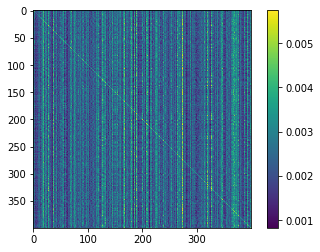

In [71]:
plt.figure()
plt.imshow(T)
plt.colorbar()
plt.show()

In [72]:
rnn = AnalyticSR(
    num_states=input_size, gamma=gamma,
    ca3_kwargs={
        'use_dynamic_lr':False, 'lr': 1E-3,
        #'parameterize': True,
        #'alpha': 1.2, 'beta': 1.2
        }
    )
np.random.seed(seed)
outputs, loss, dset = run_rnn(
    '../trained_models/test/', rnn, dataset,
    dataset_config, gamma=gamma, test_over_all=False,
    train_net=False, return_dset=True
    )

SVD did not converge. Small values added on diagonal.
SVD did not converge. Small values added on diagonal.

[   51] loss: 0.021
Time per step 0.038s, net 1.887s

[  101] loss: 0.012
Time per step 0.042s, net 3.987s

[  151] loss: 0.013
Time per step 0.049s, net 6.419s

[  201] loss: 0.015
Time per step 0.054s, net 9.121s

[  251] loss: 0.014
Time per step 0.075s, net 12.883s

[  301] loss: 0.013
Time per step 0.092s, net 17.465s

[  351] loss: 0.013
Time per step 0.083s, net 21.595s

[  401] loss: 0.013
Time per step 0.060s, net 24.584s

[  451] loss: 0.013
Time per step 0.054s, net 27.309s

[  501] loss: 0.014
Time per step 0.062s, net 30.420s

[  551] loss: 0.013
Time per step 0.048s, net 32.833s

[  601] loss: 0.013
Time per step 0.052s, net 35.424s

[  651] loss: 0.013
Time per step 0.047s, net 37.797s

[  701] loss: 0.014
Time per step 0.049s, net 40.223s

[  751] loss: 0.014
Time per step 0.050s, net 42.702s

[  801] loss: 0.014
Time per step 0.047s, net 45.042s

[  851] loss: 0


[ 7301] loss: 0.012
Time per step 0.153s, net 809.169s

[ 7351] loss: 0.013
Time per step 0.133s, net 815.796s

[ 7401] loss: 0.013
Time per step 0.146s, net 823.105s

[ 7451] loss: 0.012
Time per step 0.136s, net 829.926s

[ 7501] loss: 0.013
Time per step 0.112s, net 835.529s

[ 7551] loss: 0.012
Time per step 0.101s, net 840.591s

[ 7601] loss: 0.013
Time per step 0.107s, net 845.921s

[ 7651] loss: 0.014
Time per step 0.102s, net 851.015s

[ 7701] loss: 0.012
Time per step 0.102s, net 856.096s

[ 7751] loss: 0.012
Time per step 0.129s, net 862.550s

[ 7801] loss: 0.012
Time per step 0.109s, net 868.003s

[ 7851] loss: 0.013
Time per step 0.105s, net 873.248s

[ 7901] loss: 0.013
Time per step 0.114s, net 878.930s

[ 7951] loss: 0.014
Time per step 0.127s, net 885.258s

[ 8001] loss: 0.013
Time per step 0.126s, net 891.570s

[ 8051] loss: 0.012
Time per step 0.182s, net 900.687s

[ 8101] loss: 0.012
Time per step 0.221s, net 911.756s

[ 8151] loss: 0.013
Time per step 0.177s, net 9

In [73]:
walk_xs = dset.xs
walk_ys = dset.ys
arena_length = int(np.sqrt(dset.num_states))

# Option B: Load existing results

In [79]:
results_path = '../trained_models/03_td_discrete_corr/pval80_sigma1.5/0.6/rnn_fixedlr_alpha/4/results.p'
results_path = '../trained_models/03_hannah_dset/pval80_sigma1.5/0.6/rnn_fixedlr_alpha/2/results.p'
#results_path = '../trained_models/03_td_discrete_corr/sparse_sigma1.5/0.6/hopfield/2/results.p'
with open(results_path, 'rb') as f:
    results = pickle.load(f)
if 'hopfield' in results_path:
    outputs = results['outputs'].detach().numpy().squeeze()
else:
    outputs = results['outputs']
dset = results['dset']

In [80]:
walk_xs = dset.xs
walk_ys = dset.ys
arena_length = 10

# Make Plots

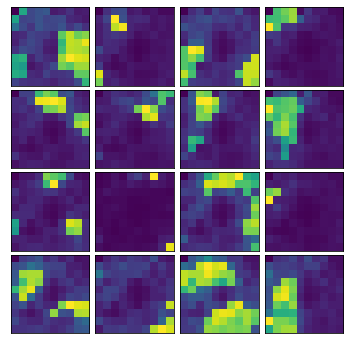

In [81]:
import matplotlib.gridspec as gridspec

grid_x = 4; grid_y = 4;

plt.figure(figsize = (6, 6))
gs1 = gridspec.GridSpec(grid_x, grid_y)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 

neurs = np.arange(outputs.shape[1])
np.random.shuffle(neurs)

idx = 0
for neur in neurs:
    firing_field = np.zeros((arena_length, arena_length))*np.nan
    for x in range(arena_length):
        for y in range(arena_length):
            frame_idxs = np.logical_and(walk_xs == x, walk_ys == y)
            fr = np.nanmean(outputs[frame_idxs, neur])
            firing_field[x,y] = fr
    firing_field[np.isnan(firing_field)] = 0    
    if not np.any(firing_field > 0): continue
    ax = plt.subplot(gs1[idx])
    plt.axis('on')
    ax.imshow(firing_field/firing_field.max(), vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    
    idx += 1
    if idx == grid_x*grid_y: break
plt.show()

# Metrics

In [75]:
from findpeaks import findpeaks
from scipy.ndimage.measurements import label

In [76]:
# Area and Peaks

def get_area_and_peaks(firing_field):
    area_thresh = ceil(0.00716197244*firing_field.size)
    masked_field = firing_field > 0.8
    labeled_array, ncomponents = label(masked_field, np.ones((3,3)))
    areas = []
    for label_id in np.unique(labeled_array):
        if label_id == 0: continue
        area = np.sum(labeled_array == label_id)
        if area < area_thresh: continue
        areas.append(area)
    return areas, len(areas)

# Spatial Info

def flatten_xy(walk_xs, walk_ys):
    max_col = walk_ys.max()
    new_bins = walk_xs * max_col + walk_ys
    return new_bins

def circular(fr):
    """
    Circularly shuffles a (neur, frames) array of firing rates, neuron by neuron.
    """

    fr = fr.copy()
    shift = np.random.choice(np.arange(1, fr.size))
    if len(fr.shape) == 2:
        num_neur, num_frames = fr.shape
        for neur in range(num_neur):
            shift = np.random.choice(np.arange(1, num_frames))
            fr[neur,:] = np.roll(fr[neur,:], shift)
        return fr
    else:
        return np.roll(fr, shift)
    
def get_mutual_info(conditions, fr):
    """
    Calculates mutual information between firing rate and a set of conditions

    Args:
        conditions: (frames,) array of conditions
        fr: (neurs, frames) array of firing rates
    Returns:
        (neurs,) array of scaler value mutual information per neuron
    """

    num_neurs, _ = fr.shape
    mean_fr = np.mean(fr, axis=1)
    mutual_info = np.zeros(num_neurs)
    for condn in np.unique(conditions):
        prob = np.sum(conditions==condn)/conditions.size
        condn_mean_fr = np.mean(fr[:,conditions==condn], axis=1)
        log_term = np.log2(condn_mean_fr/mean_fr)
        log_term[np.isnan(log_term)] = 0
        log_term[np.isinf(log_term)] = 0
        mutual_info += prob*condn_mean_fr*log_term
    return mutual_info

def calc_place_cells(xs, ys, fr, num_shuffles):
    """ Gets the spatial mutual information of each cell."""

    num_neurs, num_frames = fr.shape
    spatial_info = np.zeros(num_neurs)
    significance = np.zeros(num_neurs)
    conditions = flatten_xy(xs, ys)
    spatial_info = get_mutual_info(conditions, fr)
    
    for _ in range(num_shuffles):
        shuffled_fr = circular(fr)
        shuffled_info = get_mutual_info(conditions, shuffled_fr)
        significance += (shuffled_info < spatial_info)
    significance /= num_shuffles
    
    return spatial_info, significance

def get_metrics(outputs, dset):
    walk_xs = dset.xs.astype(int)
    walk_ys = dset.ys.astype(int)
    arena_length = 10
    
    areas = []
    ncomps = []

    spatial_info, significance = calc_place_cells(
        walk_xs, walk_ys, outputs.T, 100
        )

    for neur in np.arange(outputs.shape[1]):
        firing_field = np.zeros((arena_length, arena_length))*np.nan
        for x in range(arena_length):
            for y in range(arena_length):
                frame_idxs = np.logical_and(walk_xs == x, walk_ys == y)
                fr = np.nanmean(outputs[frame_idxs, neur])
                firing_field[x,y] = fr
        firing_field[np.isnan(firing_field)] = 0

        # Area?
        area, ncomp = get_area_and_peaks(firing_field)
        areas.append(np.sum(area))
        ncomps.append(ncomp)
    return np.array(areas), np.array(ncomps), spatial_info

In [ ]:
areas, ncomps, spatial_info = get_metrics(outputs, input)

In [ ]:
np.mean(ncomps)

In [63]:
np.mean(areas)/(arena_length**2)

0.09834443981674303

In [64]:
sum(ncomps==1)/ncomps.size

0.2857142857142857

In [65]:
rnn.ca3.beta

1.2